In [47]:
import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

crit_thresh = -0.115202
warn_thresh = -0.028871

# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler_before.joblib')
iso_model = load('./model/iso_model_before.joblib')

# Load datasets
#df_val = pd.read_csv("./data/validate.csv")
df_val = pd.read_csv("./../../data/dataSet2_prepared.csv")
df_val = df_val[df_val['devID'] == 103]
#df1 = pd.read_csv("./data/dev101_prepared.csv")
#df2 = pd.read_csv("./data/dev102_prepared.csv")

#df_val = pd.concat([df1, df2], ignore_index=True)
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [48]:
df_val

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,iso_score,iso_risk,lstm_score,lstm_risk,confidence,rf_risk
0,2025-09-11 00:00:01.157,103,17.700001,0.0,27.750000,83.849998,9.382449,8.640352,99.911812,0.068957,0,0.116043,0,NaN,NaN
1,2025-09-11 00:00:16.183,103,17.700001,0.0,27.799999,83.099998,0.322535,8.640352,99.911812,0.076844,0,0.116043,0,NaN,NaN
2,2025-09-11 00:00:31.220,103,17.700001,0.0,27.799999,83.099998,0.322535,8.640352,99.911812,0.076844,0,0.116043,0,NaN,NaN
3,2025-09-11 00:00:46.316,103,17.700001,0.0,28.100000,83.000000,0.472299,8.640352,99.911812,0.074236,0,0.116043,0,NaN,NaN
4,2025-09-11 00:01:01.346,103,17.700001,0.0,27.950000,83.049999,0.397417,8.640352,99.911812,0.074221,0,0.104980,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38668,2025-10-21 02:38:56.350,103,20.100000,0.0,32.799999,62.400002,9.528192,8.640356,99.911819,0.034995,0,0.021407,0,0.999999,0.0
38669,2025-10-21 02:40:25.359,103,20.100000,0.0,32.900002,61.700001,2.470316,8.640356,99.911819,0.049861,0,0.021114,0,0.999999,0.0
38670,2025-10-21 02:43:27.012,103,20.100000,0.0,32.700001,61.099998,7.983696,8.640357,99.911812,0.028616,0,0.025582,0,0.999999,0.0
38671,2025-10-21 02:45:59.409,103,20.100000,0.0,32.299999,62.500000,11.278135,8.640360,99.911819,0.030232,0,0.027337,0,0.999999,0.0


In [49]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo,lat,lng,iso_score,iso_risk,lstm_score,lstm_risk,confidence,rf_risk
count,38673.0,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,26208.000000,26208.000000
mean,103.0,18.372355,0.072619,28.063283,79.543992,6.687133,8.640352,100.235867,-247.374319,0.050526,0.220049,0.007266,0.950032,0.008165
std,0.0,1.171645,0.641499,3.488693,13.433036,5.960481,0.000116,17.030171,4731.364317,0.242346,2.346000,0.113360,0.076458,0.089995
min,103.0,0.000000,0.000000,6.550000,24.228929,0.192656,8.633333,99.883331,-86325.800490,0.000000,0.000819,0.000000,0.000000,0.000000
25%,103.0,17.349999,0.000000,25.200001,68.599998,2.485212,8.640347,99.911804,-0.005599,0.000000,0.013080,0.000000,0.945023,0.000000
50%,103.0,18.500000,0.000000,26.700001,83.549999,4.395669,8.640356,99.911812,0.024404,0.000000,0.025084,0.000000,0.997499,0.000000
75%,103.0,19.450000,0.000000,31.200001,90.250000,11.142646,8.640365,99.911819,0.062844,0.000000,0.072756,0.000000,0.999999,0.000000
max,103.0,21.200001,36.321999,36.900002,98.599998,32.000000,8.640397,995.750000,4069.171573,2.000000,75.858818,2.000000,1.000000,1.000000


## Threshold

In [50]:
#def rule_based_risk(row):
#   score = 0
#   
#   # Rainfall (mm/h)
#   if row['rain'] > 25:
#       score += 2
#   elif row['rain'] > 10:
#       score += 1
#
#   # Soil moisture (%)
#   if row['soil'] > 60:
#       score += 2
#   elif row['soil'] > 45:
#       score += 1
#
#   # Temperature (°C)
#   if row['temp'] < 27:
#       score += 2
#   elif row['temp'] < 32:
#       score += 1
#
#   # Humidity (%)
#   if row['humi'] > 80:
#       score += 2
#   elif row['humi'] > 65:
#       score += 1
#
#   # Geophone (Hz)
#   if row['geo'] > 25:
#       score += 1
#   elif row['geo'] > 10:
#       score += 0.5
#
#   if score >= 6:
#       return "Critical"
#   elif score >= 3:
#       return "Warning"
#   else:
#       return "Normal"
#
#feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
#X_val = df_val[feature_cols].values
#X_val_scaled = scaler.transform(X_val)
#
#df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
#
#crit_thresh = np.percentile(df_val['anomaly_score'], 0.5)
#warn_thresh = np.percentile(df_val['anomaly_score'], 5)
#
#def model_based_risk(score):
#   if score < crit_thresh:
#       return "Critical"
#   elif score < warn_thresh:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['model_risk'] = df_val['anomaly_score'].apply(model_based_risk)
#df_val['rule_risk'] = df_val.apply(rule_based_risk, axis=1)
#
#risk_levels = {'Normal': 0, 'Warning': 1, 'Critical': 2}
#
#def combine_weighted_risks(model_risk, rule_risk, w_model=0.6, w_rule=0.4):
#   score = w_model * risk_levels[model_risk] + w_rule * risk_levels[rule_risk]
#   
#   if score >= 1.5:
#       return "Critical"
#   elif score >= 0.5:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['predicted_risk'] = df_val.apply(
#    lambda row: combine_weighted_risks(row['model_risk'], row['rule_risk']),
#    axis=1
#)
#
#print(df_val[['soil', 'rain', 'temp', 'humi', 'geo',
#              'anomaly_score', 'model_risk', 'rule_risk', 'predicted_risk']].head())

In [51]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)


#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)
#crit_thresh = -0.094870
#warn_thresh = -0.042534

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)

In [52]:
#print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.433))
#print("warn_thresh:", np.percentile(df_val['anomaly_score'], 2.226))

In [53]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
             soil        rain        temp        humi         geo
count  294.000000  294.000000  294.000000  294.000000  294.000000
mean    18.278231    5.457803   24.147619   96.285302   10.340855
std      1.748364    4.377143    1.567152    6.886251    8.357509
min      0.000000    0.000000    6.550000   24.228929    0.260730
25%     17.400000    3.632200   23.600000   96.500000    2.673818
50%     18.500000    4.470400   24.100000   97.300003    8.785762
75%     19.000000    6.985000   24.600000   97.800003   15.183126
max     20.799999   36.321999   35.599998   98.300003   31.984940


In [54]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
               soil          rain          temp          humi           geo
count  15315.000000  15315.000000  15315.000000  15315.000000  15315.000000
mean      18.463818      0.075382     27.470503     81.151880      6.843951
std        1.287843      0.327631      4.320358     17.328629      7.051271
min        0.000000      0.000000     19.425000     40.799999      0.192656
25%       17.500000      0.000000     24.500000     60.400002      0.597902
50%       18.700001      0.000000     25.000000     89.300003      3.424819
75%       19.400000      0.000000     32.750000     94.199997     12.141922
max       21.200001      3.492500     36.900002     98.350002     32.000000


In [55]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
               soil          rain          temp          humi           geo
count  23064.000000  23064.000000  23064.000000  23064.000000  23064.000000
mean      18.312822      0.002138     28.506815     78.262916      6.536428
std        1.073545      0.026400      2.712477      9.780083      5.045875
min       17.000000      0.000000     24.500000     55.500000      0.204096
25%       17.299999      0.000000     26.200001     70.099998      2.621130
50%       17.799999      0.000000     27.700001     79.549999      4.406418
75%       19.500000      0.000000     30.700001     86.349998     10.505537
max       21.200001      0.838200     35.600000     98.599998     27.828722


C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


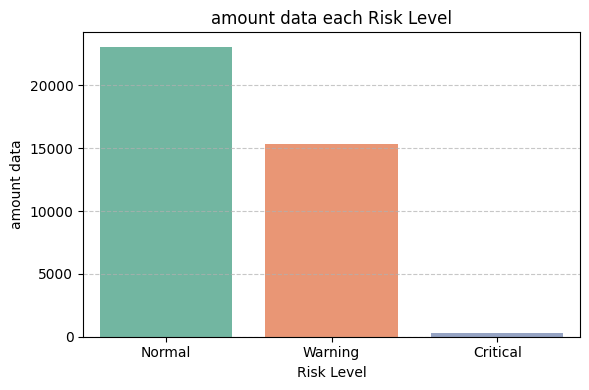

In [56]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

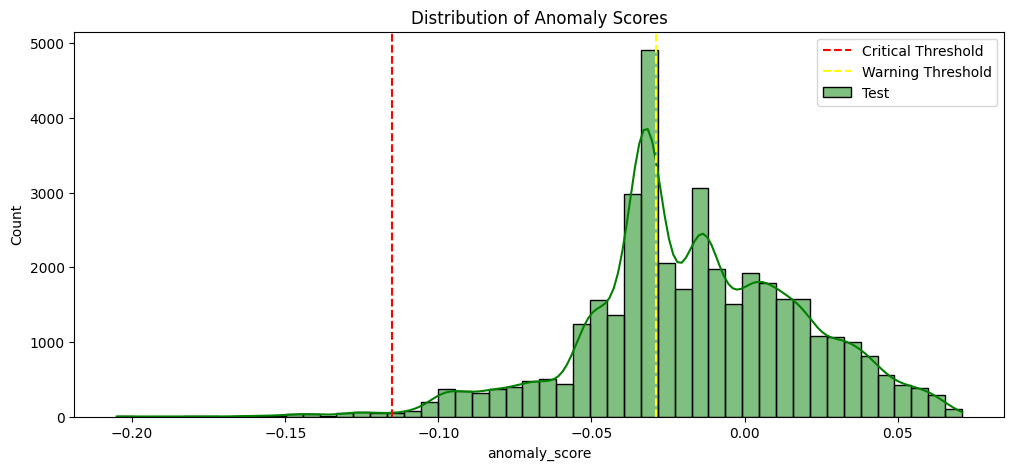

In [57]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## Z-score Outlier

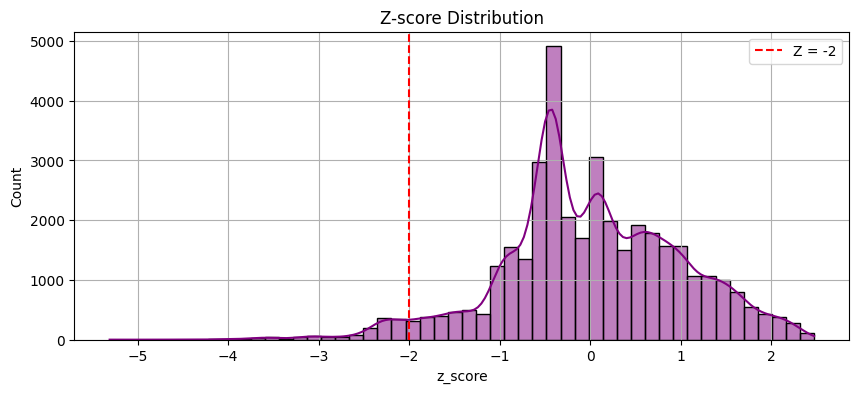

In [58]:
# ==== Z-score Outlier ====

mean_score = df_val['anomaly_score'].mean()
std_score = df_val['anomaly_score'].std()
df_val['z_score'] = (df_val['anomaly_score'] - mean_score) / std_score
df_val['z_outlier'] = df_val['z_score'].apply(lambda z: 'Anomaly' if z < -2 else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['z_score'], kde=True, bins=50, color='purple')
plt.axvline(-2, color='red', linestyle='--', label='Z = -2')
plt.title("Z-score Distribution")
plt.legend()
plt.grid(True)
plt.show()

## Mahalanobis Distance

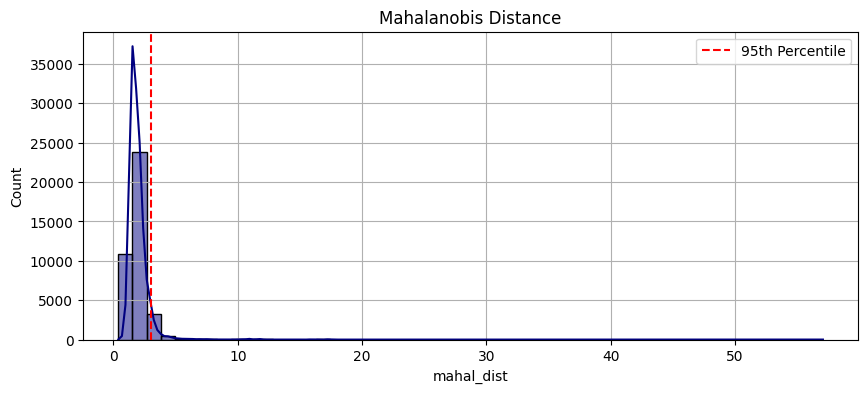

In [59]:
mean_vec = np.mean(X_val_scaled, axis=0)
cov_matrix = np.cov(X_val_scaled, rowvar=False)
inv_covmat = np.linalg.inv(cov_matrix)

df_val['mahal_dist'] = [mahalanobis(x, mean_vec, inv_covmat) for x in X_val_scaled]
mahal_thresh = np.percentile(df_val['mahal_dist'], 95)
df_val['mahal_outlier'] = df_val['mahal_dist'].apply(lambda d: 'Anomaly' if d > mahal_thresh else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['mahal_dist'], bins=50, kde=True, color='navy')
plt.axvline(mahal_thresh, color='red', linestyle='--', label='95th Percentile')
plt.title("Mahalanobis Distance")
plt.legend()
plt.grid(True)
plt.show()

## Percentile Threshold 5%

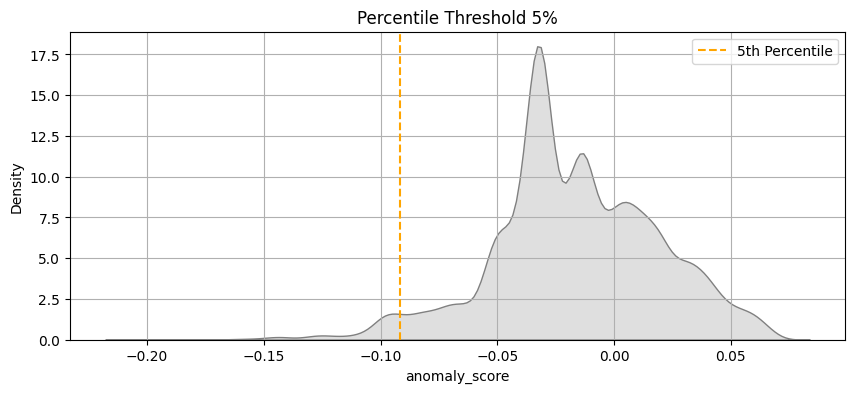

In [60]:
percentile = np.percentile(df_val['anomaly_score'], 3)
df_val['percentile_outlier'] = df_val['anomaly_score'].apply(lambda s: 'Anomaly' if s < percentile else 'Normal')

plt.figure(figsize=(10,4))
sns.kdeplot(df_val['anomaly_score'], fill=True, color='gray')
plt.axvline(percentile, color='orange', linestyle='--', label='5th Percentile')
plt.title("Percentile Threshold 5%")
plt.legend()
plt.grid(True)
plt.show()

## PCA

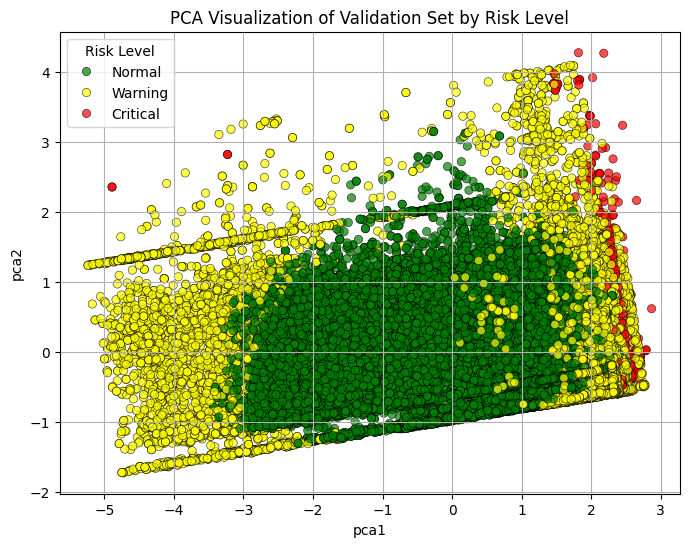

In [61]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [62]:
explained_var = pca.explained_variance_ratio_
print(f"PCA explain {explained_var[0]*100:.2f}% and {explained_var[1]*100:.2f}% of data")


PCA explain 79.58% and 15.56% of data


In [63]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
humi  0.813944  0.145209
rain  0.025921  0.043877
soil -0.003070  0.004656
geo  -0.161190  0.985862
temp -0.557522 -0.071023


## Summary Statistics

In [64]:
print("\n== Z-score Outlier ==")
print(df_val['z_outlier'].value_counts())


== Z-score Outlier ==
z_outlier
Normal     37296
Anomaly     1377
Name: count, dtype: int64


In [65]:
print("\n== Percentile Outlier ==")
print(f"5th Percentile Threshold: {percentile:.4f}")
print(df_val['percentile_outlier'].value_counts())


== Percentile Outlier ==
5th Percentile Threshold: -0.0917
percentile_outlier
Normal     37512
Anomaly     1161
Name: count, dtype: int64


In [66]:
print("\n== Mahalanobis Outlier ==")
print(f"95th Percentile of Mahalanobis Distance: {mahal_thresh:.2f}")
print(df_val['mahal_outlier'].value_counts())


== Mahalanobis Outlier ==
95th Percentile of Mahalanobis Distance: 3.03
mahal_outlier
Normal     36739
Anomaly     1934
Name: count, dtype: int64


In [67]:
overlap = df_val[
    (df_val['z_outlier'] == 'Anomaly') &
    (df_val['percentile_outlier'] == 'Anomaly') &
    (df_val['mahal_outlier'] == 'Anomaly')
]
print(f"Anomalies detected by ALL 3 methods: {len(overlap)}")


Anomalies detected by ALL 3 methods: 813


In [68]:
df_val['combined_outlier'] = df_val.apply(
    lambda row: (
        row['z_outlier'] == 'Anomaly' or
        row['percentile_outlier'] == 'Anomaly' or
        row['mahal_outlier'] == 'Anomaly'
    ),
    axis=1
)

print("\n== Combined Outlier ==")
print(df_val['combined_outlier'].value_counts())


== Combined Outlier ==
combined_outlier
False    36260
True      2413
Name: count, dtype: int64


In [69]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil      rain       temp       humi        geo
predicted_risk                                                      
Critical        18.278231  5.457803  24.147619  96.285302  10.340855
Normal          18.312822  0.002138  28.506815  78.262916   6.536428
Warning         18.463818  0.075382  27.470503  81.151880   6.843951


In [70]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      23064
Warning     15315
Critical      294
Name: count, dtype: int64


In [71]:
def risk_from_combined(row):
    if row['combined_outlier']:
        if row['anomaly_score'] < crit_thresh:
            return 'Critical'
        elif row['anomaly_score'] < warn_thresh:
            return 'Warning'
        else:
            return 'Warning'  
    return 'Normal'

df_val['risk_level_final'] = df_val.apply(risk_from_combined, axis=1)
print("\n== risk level final ==")
print(df_val['risk_level_final'].value_counts())


== risk level final ==
risk_level_final
Normal      36260
Warning      2119
Critical      294
Name: count, dtype: int64


In [72]:
print("\n== Risk final Proportion ==")
print("Validation:", df_val['risk_level_final'].value_counts(normalize=True))


== Risk final Proportion ==
Validation: risk_level_final
Normal      0.937605
Warning     0.054793
Critical    0.007602
Name: proportion, dtype: float64


In [73]:
print("\n== Risk Proportion ==")
print("Validation:", df_val['predicted_risk'].value_counts(normalize=True))


== Risk Proportion ==
Validation: predicted_risk
Normal      0.596385
Warning     0.396013
Critical    0.007602
Name: proportion, dtype: float64


##  Signal-to-Noise Ratio (SNR)

In [74]:
def compute_snr(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal if std_signal != 0 else 0

for col in feature_cols:
    snr = compute_snr(df_val[col])
    print(f"SNR of {col}: {snr:.2f}")


SNR of soil: 15.68
SNR of rain: 0.11
SNR of temp: 8.04
SNR of humi: 5.92
SNR of geo: 1.12


In [75]:
for col in feature_cols:
    normal_snr = compute_snr(df_val[df_val['predicted_risk'] == 'Normal'][col])
    anomaly_snr = compute_snr(df_val[df_val['predicted_risk'] != 'Normal'][col])
    print(f"{col}: Normal SNR={normal_snr:.2f}, Anomaly SNR={anomaly_snr:.2f}")


soil: Normal SNR=17.06, Anomaly SNR=14.22
rain: Normal SNR=0.08, Anomaly SNR=0.18
temp: Normal SNR=10.51, Anomaly SNR=6.36
humi: Normal SNR=8.00, Anomaly SNR=4.70
geo: Normal SNR=1.30, Anomaly SNR=0.97


## Mean Absolute Error (MAE)

In [76]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
interval = df_val['timestamp'].diff().median()
print(f"Sampling interval: {interval}")


Sampling interval: 0 days 00:00:30.099000


In [77]:
window_size = int(pd.Timedelta('1H') / interval)
print(f"Rolling window size for 1 hour: {window_size}")


Rolling window size for 1 hour: 119


C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\504831528.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


In [78]:
interval = df_val['timestamp'].diff().median()
window_size = int(pd.Timedelta('1H') / interval)

print(f"Using rolling window size = {window_size} for 1 hour")

for col in feature_cols:
    df_val[f'{col}_roll_mean'] = df_val[col].rolling(window=window_size, center=True).mean()
    df_val[f'{col}_mae'] = (df_val[col] - df_val[f'{col}_roll_mean']).abs()

    mae = df_val[f'{col}_mae'].mean()
    print(f"MAE for {col} (vs rolling mean): {mae:.2f}")


Using rolling window size = 119 for 1 hour
MAE for soil (vs rolling mean): 0.04
MAE for rain (vs rolling mean): 0.06
MAE for temp (vs rolling mean): 0.31
MAE for humi (vs rolling mean): 1.34
MAE for geo (vs rolling mean): 3.91


C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\2248412977.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


## Cross-Correlation

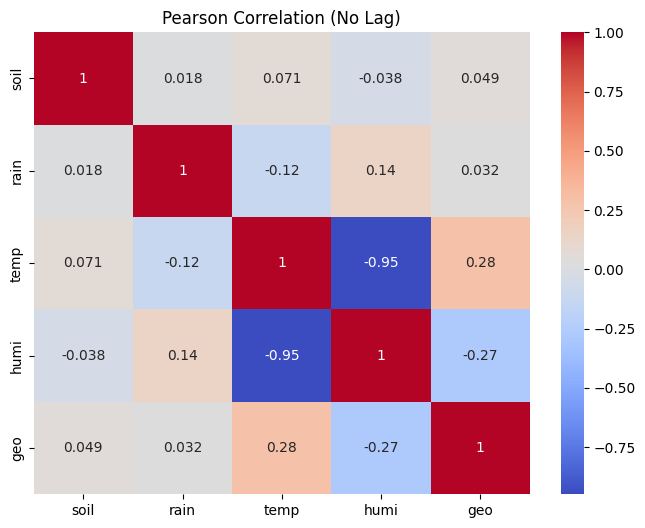

In [79]:
corr_matrix = df_val[feature_cols]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation (No Lag)")
plt.show()

In [80]:
def lag_corr(x, y, max_lag=window_size*10):
    lags = []
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        lags.append(lag)
        corrs.append(corr)
    return lags, corrs


C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\1202832202.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\1202832202.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


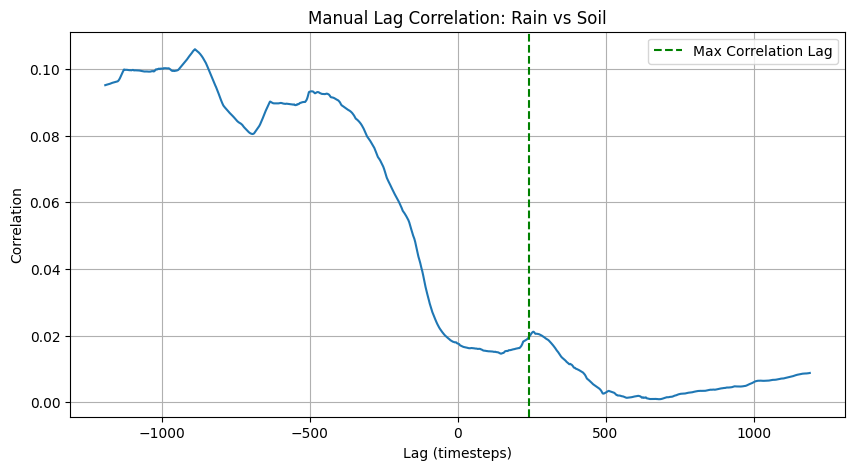

In [81]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values
lags, corrs = lag_corr(x, y, max_lag=window_size*10)

plt.figure(figsize=(10, 5))
plt.plot(lags, corrs)
plt.axvline(x=np.argmax(corrs) - 60, color='green', linestyle='--', label='Max Correlation Lag')
plt.title("Manual Lag Correlation: Rain vs Soil")
plt.xlabel("Lag (timesteps)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\3179048846.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\3179048846.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


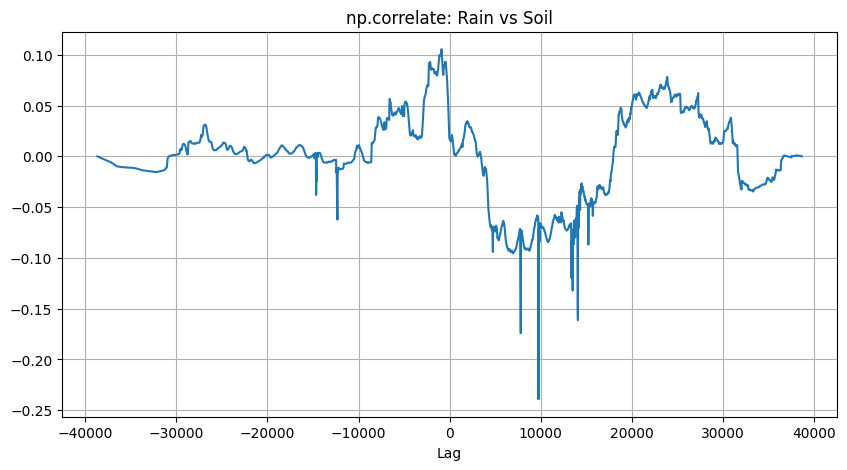

In [82]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

corr = np.correlate(x, y, mode='full') / len(x)
lags = np.arange(-len(x)+1, len(x))

plt.figure(figsize=(10,5))
plt.plot(lags, corr)
plt.title("np.correlate: Rain vs Soil")
plt.xlabel("Lag")
plt.grid(True)
plt.show()


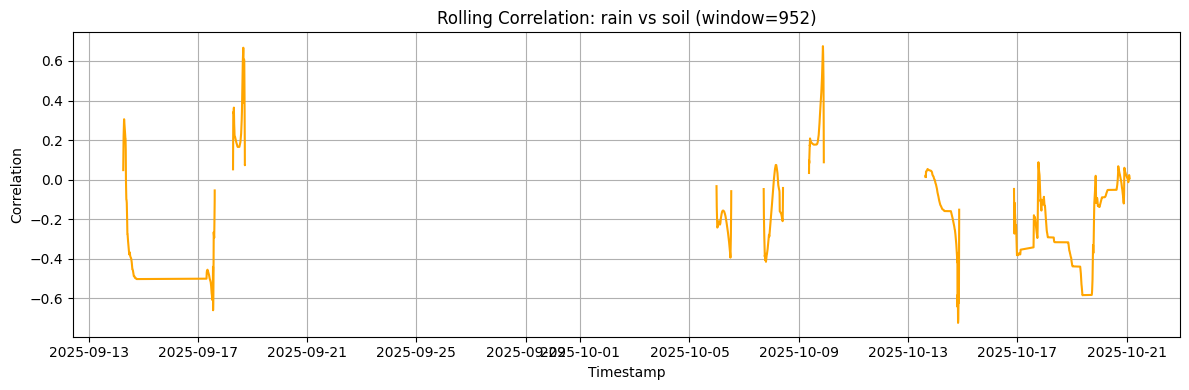

In [83]:
# ตัวอย่าง: ถ้า sampling ทุก 10 นาที → 48 จุด = 8 ชั่วโมง
df = df_val.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

rolling_corr = df['rain'].rolling(window_size*8).corr(df['soil'])

plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], rolling_corr, color='orange')
plt.title(f"Rolling Correlation: rain vs soil (window={window_size*8})")
plt.xlabel("Timestamp")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

## histogram

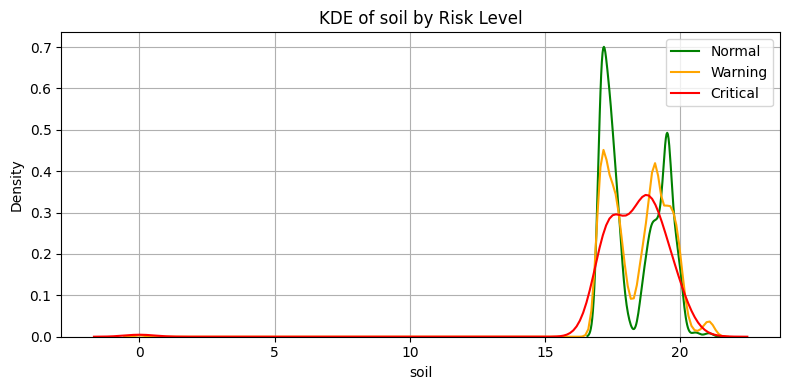

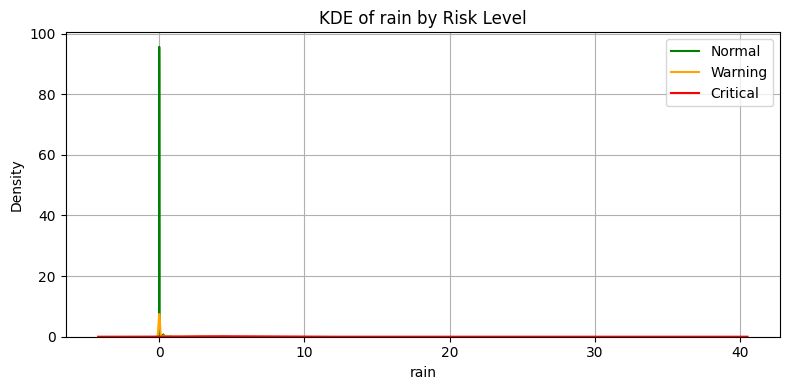

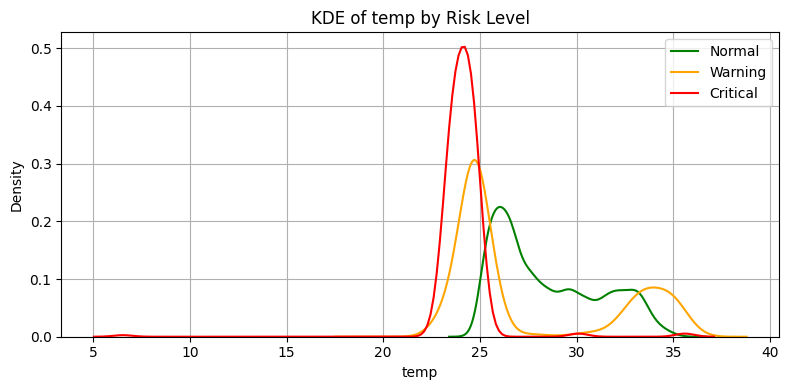

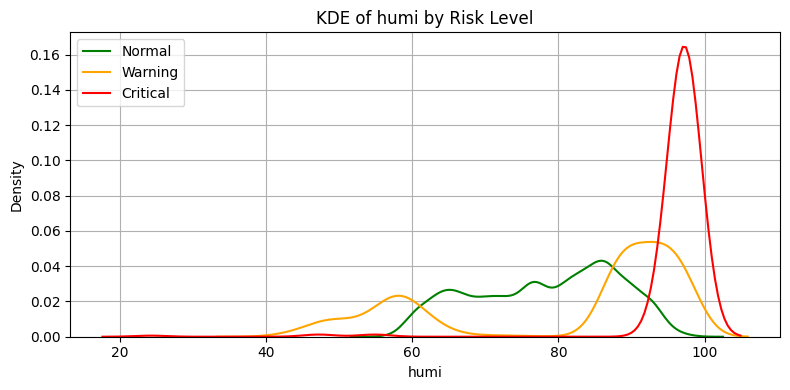

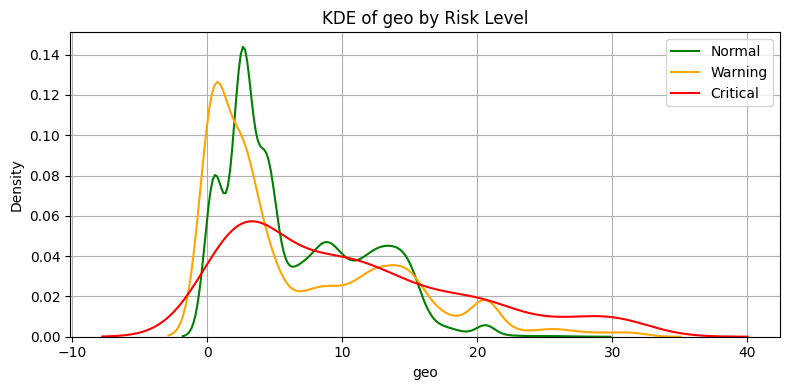

In [84]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_5936\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

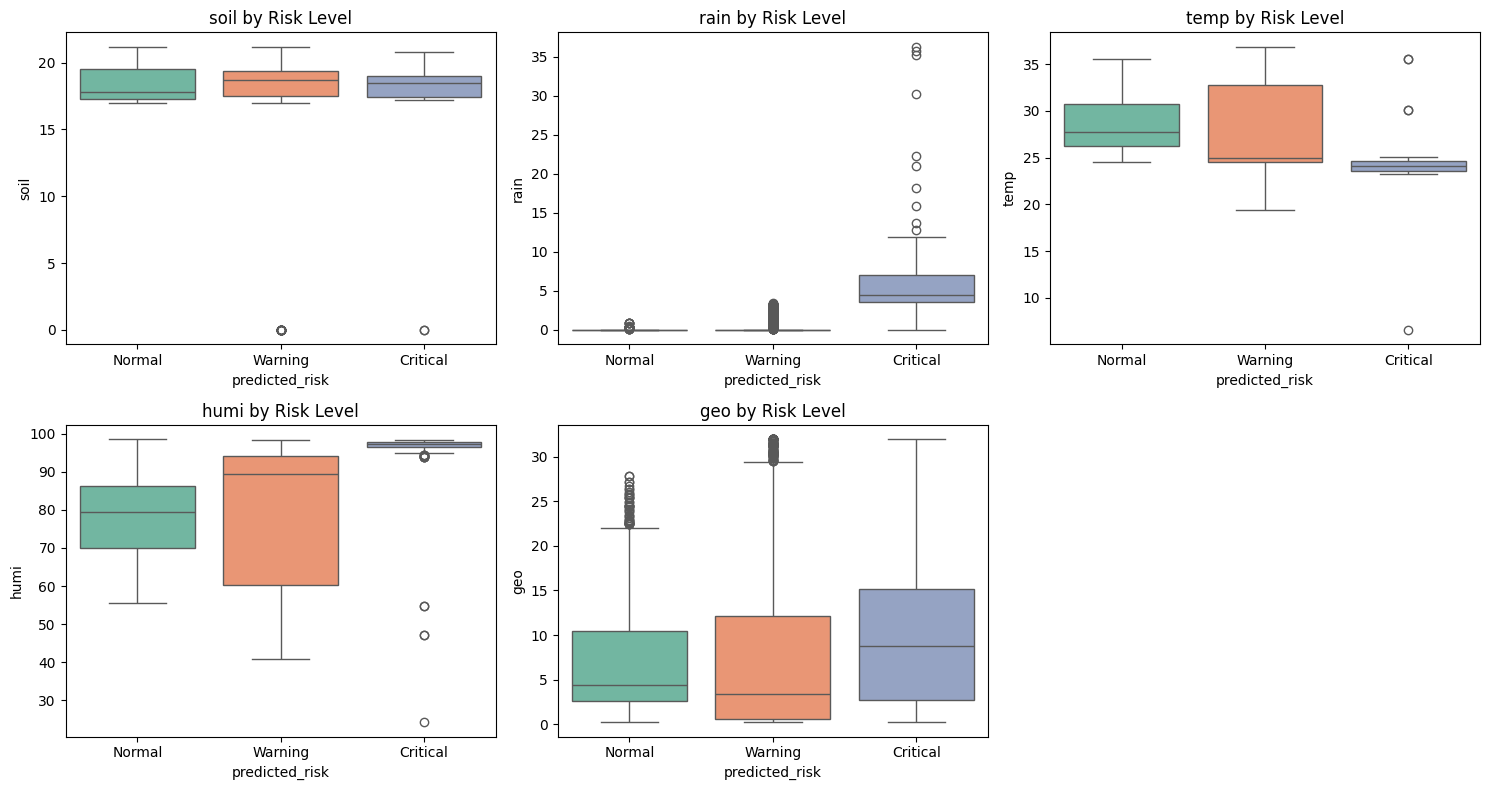

In [85]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [86]:
df['timestamp'].min()

Timestamp('2025-09-11 00:00:01.157000')

In [87]:
df['timestamp'].max()

Timestamp('2025-10-21 02:47:11.154000')

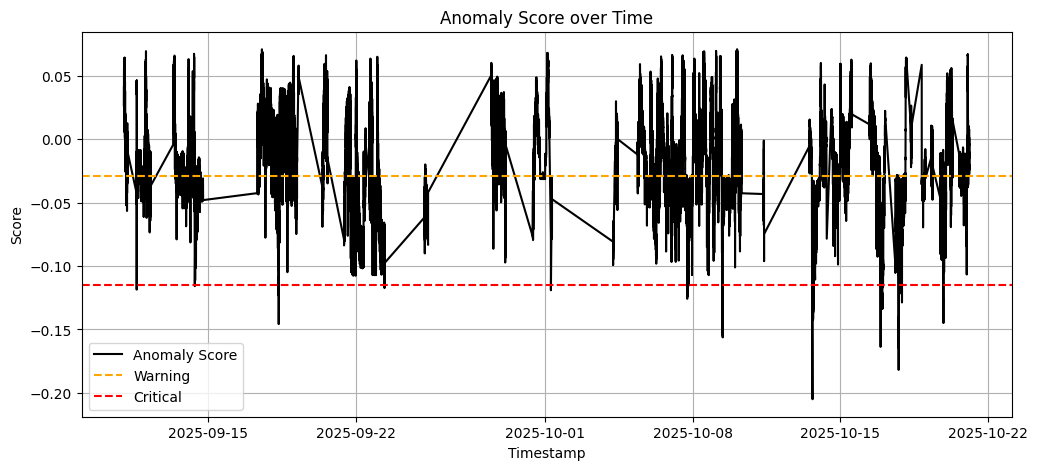

In [88]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

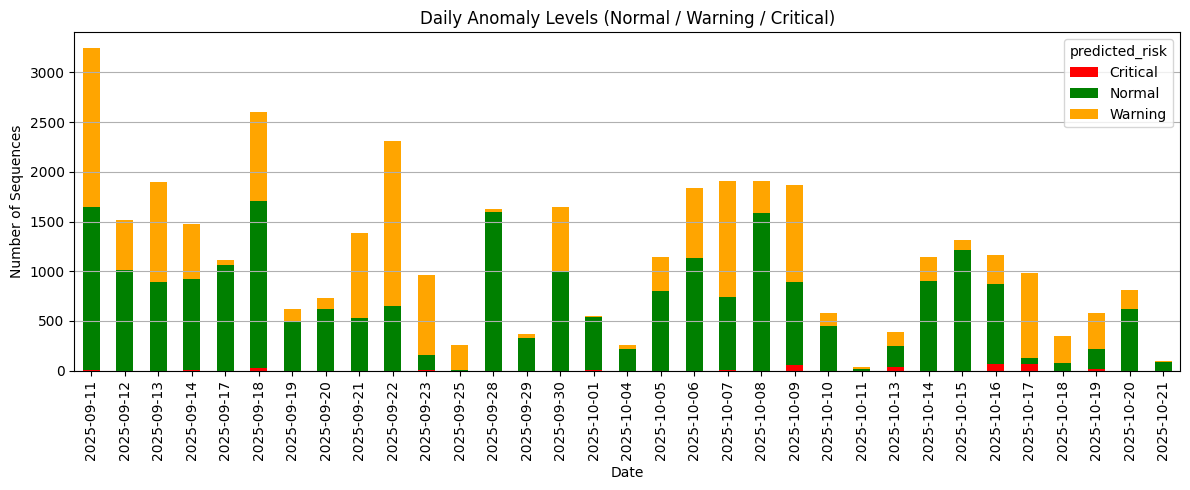

In [89]:

df_results = df_val
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


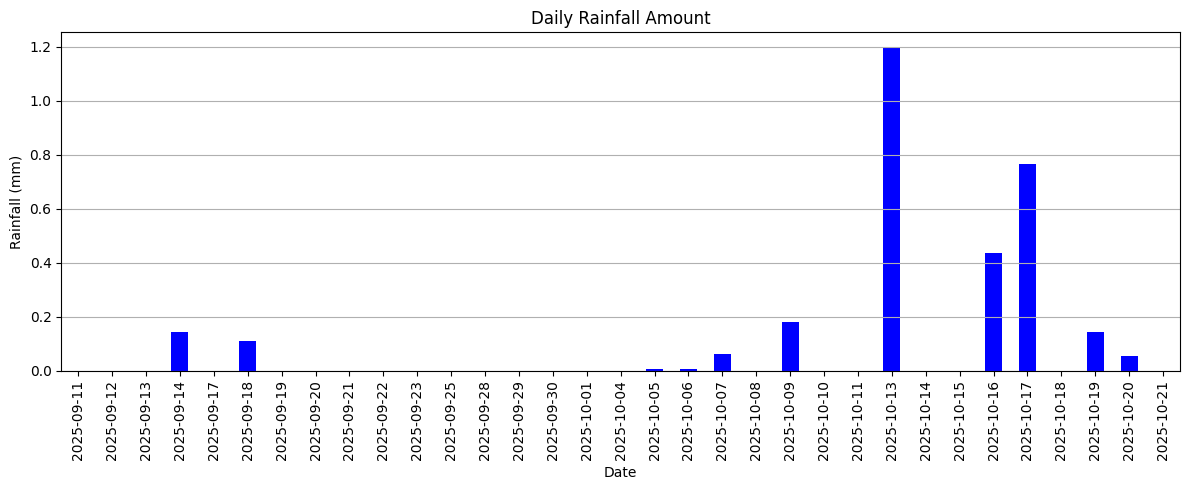

In [90]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


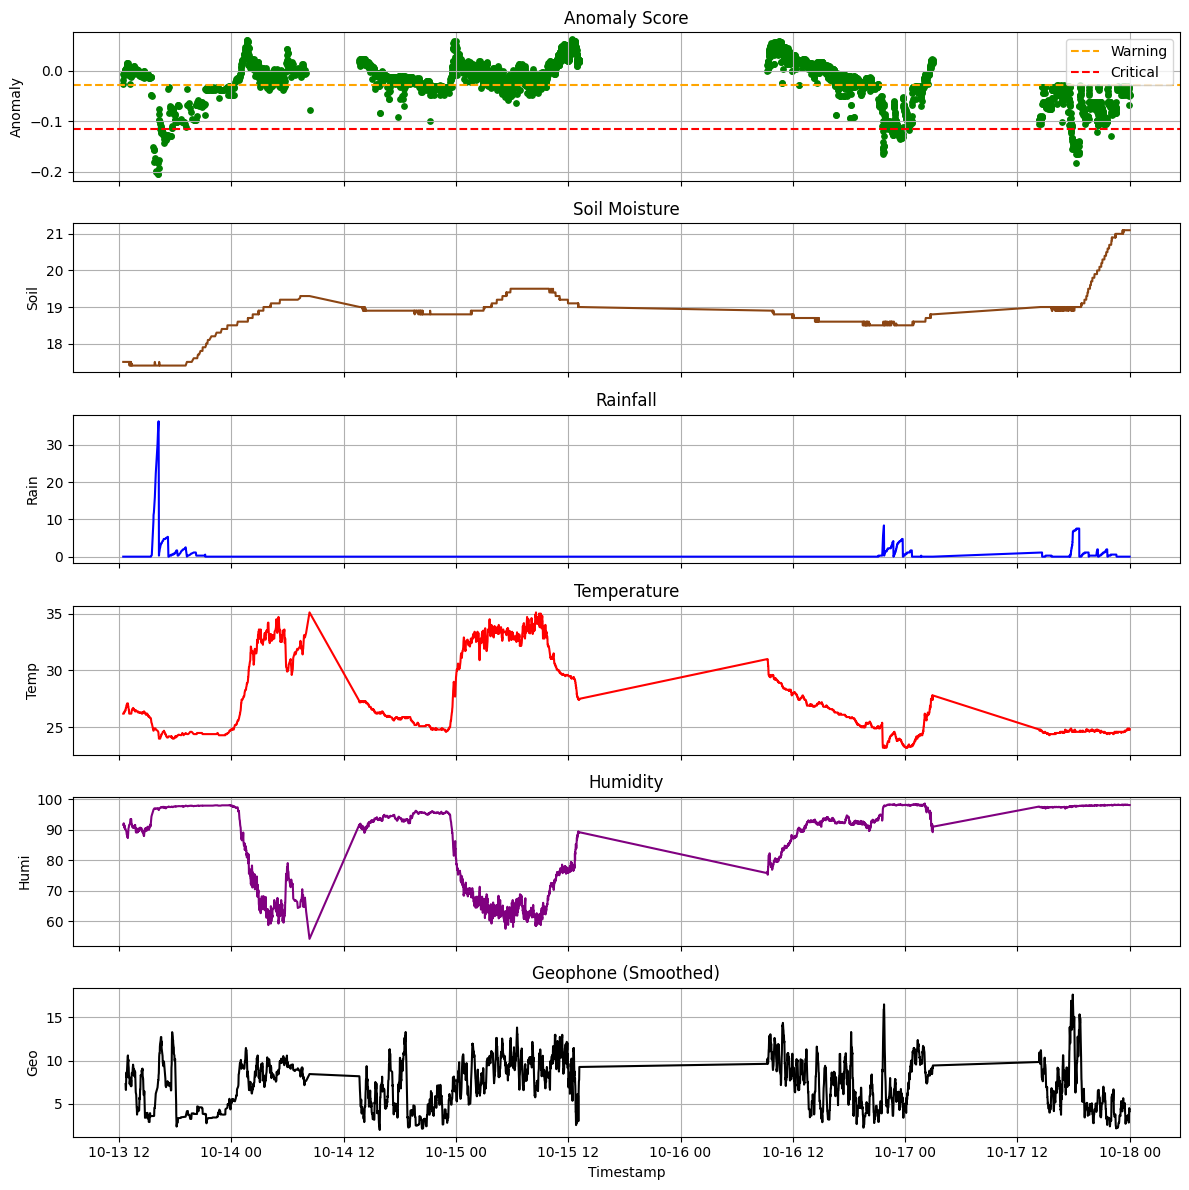

In [91]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
#df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-10-13":"2025-10-17"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()
